In [34]:
import numpy as np
import os
import itertools
from skimage import io
import sys
import h5py
import glob
from skimage import io
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pickle

#### MODULES used in the code
sys.path.insert(0,'/media/DATA/jbonato/astro_segm/U-net/pre_proc/')
from img_Sp_Sharp import create_img
from mask_roi_from_fiji import create_mask
from gen_single_astro import save_im,tune_th

sys.path.insert(0,'/media/DATA/jbonato/astro_segm/U-net/net/')
from sel_active_reg_gen import *

#SET IMAGES DIM
N = 256 
M = 256 

# SET Parameters
### dict active map extraction module
# dict_param = {
#     'list':[0,40,80,120,160],
#     'blocks':15,
#     'threads':32,
#     'BPM_ratio':3,
#     'bb':96,
#     'N_pix_st':100, #starting minimum area
#     'astr_min':80, # approx. 0.9 min in dataset
#     'percentile': 80,
#     'pad':5
# }

dict_param = {
    'list':[i for i in range(0,400,30)],
    'blocks':28,
    'threads':20,
    'BPM_ratio':2,
    'bb':40,    
    'N_pix_st':35, #starting minimum area
    'astr_min':17, # approx. 0.9 min in dataset
    'percentile': 90,
    'pad':5
}
dict_param['cnt_min']=60
dict_param

{'list': [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390],
 'blocks': 28,
 'threads': 20,
 'BPM_ratio': 2,
 'bb': 40,
 'N_pix_st': 35,
 'astr_min': 17,
 'percentile': 90,
 'pad': 5,
 'cnt_min': 60}

# Get Somata Area

In [35]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from sklearn.externals.joblib import Parallel, delayed
from skimage.restoration import denoise_nl_means,estimate_sigma
from scipy import signal
from joblib import Parallel, delayed
import os
import h5py
from numba import cuda,float32,uint16,float64  


@cuda.jit
def sel_active_gpu(T,per_mat,stack,im_out,cover,BPM_ratio,stp):
    b_dimx = cuda.blockDim.x
    b_dimy = cuda.blockDim.y
    
    bx = cuda.blockIdx.x  
    by = cuda.blockIdx.y
            
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    for bz in range(T):
        if stack[bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz,bx//BPM_ratio,by//BPM_ratio]:
            cuda.atomic.add(im_out,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)
   
        cuda.atomic.add(cover,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

def percent_matrix_par(stack,t,listx,bb,per_tile):
    listy = listx
    dim = len(listx)
    matrix= t*np.ones((dim+1,dim),dtype=np.float32)
    
    for i in range(dim):
        for j in range(dim):
            
            x = listx[i] 
            y = listy[j]
            matrix[i,j] = np.percentile(stack[t,x:x+bb,y:y+bb],per_tile)  
         
    return matrix.astype(np.float32)    

def sel_active_reg_gpu(stack,dict_params,verbose=True):
    
    step_list = dict_params['list']
    stp = step_list[1]-step_list[0]
    blocks = dict_params['blocks']
    threads = dict_params['threads']
    BPM_ratio = dict_params['BPM_ratio']#block percent_mat ratio
    bb = dict_params['bb']
    
    N_pix_st = dict_params['N_pix_st']
    astr_min = dict_params['astr_min']
    per_tile = dict_params['percentile']
    cnt_min =  dict_params['cnt_min']
    
    T,N,M =stack.shape
    cuda.select_device(2)    
    ### allocate in ram
    im_out = np.zeros((T,N,M),dtype=np.float32)
    cover = np.zeros((T,N,M),dtype=np.intc)
    ### allocate and load in DRAM
    stack_gpu = cuda.to_device(stack.astype(np.float64))
    im_out_g = cuda.to_device(im_out)
    cover_g = cuda.to_device(cover)
 
    threadsperblock = (threads,threads)
    blockspergrid = (blocks,blocks)
    # compute percentile in patches
    percent_list = Parallel(n_jobs=10)(delayed(percent_matrix_par) (stack,i,step_list,bb,per_tile) for i in range(T))
    percentiles = np.asarray(percent_list)
    mat_per = percentiles[:,:-1,:]
    
    mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]# reorder the embarasing parallel collection of mat
    print(mat_per.shape)
    ### allocate percentile matrix
    mat_per_g = cuda.to_device(mat_per)    
    sel_active_gpu[blockspergrid, threadsperblock](T,mat_per_g,stack_gpu,im_out_g,cover_g,BPM_ratio,stp)
    im_out = im_out_g.copy_to_host()
    cover = cover_g.copy_to_host()
    mask_tot  = im_out/cover    
          
    
    #th_ =round(T*0.6)
    th_ = round(T*0.5)
   
    cnt=0
    starting_th = th_
    flag_th=True
    N_pix = N_pix_st
    while(cnt<cnt_min and N_pix>=N_pix_st*0.3 and th_>round(T*0.3)):
        if flag_th:
            mask_tot_s = np.sum(mask_tot,axis=0)
            mask_tot_s[mask_tot_s<=th_]=0
            mask_tot_s[mask_tot_s>0.5]=255
            mask_tot_s= np.uint8(mask_tot_s)    
            ret, labels_r = cv2.connectedComponents(mask_tot_s)
            flag_th = False
    
        labels = labels_r.copy()
        cnt=0
        for i in range(1, ret):
            pts =  np.where(labels == i)    

            if len(pts[0]) < N_pix:
                  
                labels[pts] = 0
            else:
                cnt+=1
               
                labels[pts] = 255         
        
        N_pix-=10
        if N_pix<=astr_min and (starting_th-th_)<105:
            
            th_-=25
            flag_th = True  
            N_pix=N_pix_st
            
    if verbose:
        print('Zones',cnt)
    ret, labels = cv2.connectedComponents(np.uint8(labels))
    for i in range(1, ret):
        pts =  np.where(labels == i)    
        if len(pts[0])<astr_min//4:
            labels[pts]=0
    labels[labels>0]=1
    return labels

In [37]:
path = '/media/DATA/jbonato/segm_project/set_large/'
res = np.empty((24,7))
fov = 0
for j in range(1,2):
    if j !=20:
        
        if len(str(j))==1:
            test_folder_str='00'+str(j)
        else:
            test_folder_str='0'+str(j)
        
        path_f = path+str(j)+'/'
        item = glob.glob(path_f+'*')
        print(path_f,item)
        item = [i for i in item if not('enh' in i)]
        stack = io.imread(item[0])
        stack = stack[:,3:-2,3:-2]
        T,N,_ = stack.shape
        
        Res_file_path='/media/DATA/jbonato/segm_project/set_large/dataset/SMALL_'+test_folder_str+'_nf.hdf5'
        
        Res_mat = np.empty((N,N,2))
        dset= h5py.File(Res_file_path,'r') 
        print(dset.keys())
        Res_mat[:,:,0] =  np.asarray(dset['Values_soma'])
        #Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])

        qq =sel_active_reg_gpu(stack,dict_param,verbose=False)
        print(qq.shape)

/media/DATA/jbonato/segm_project/set_large/1/ ['/media/DATA/jbonato/segm_project/set_large/1/TSeries-06072018-1654-1089_Ch2__movie_corrected_aligned_im_enh.tif', '/media/DATA/jbonato/segm_project/set_large/1/TSeries-06072018-1654-1089_Ch2__movie_corrected_aligned.tiff']
<KeysViewHDF5 ['Values_soma']>
(250, 14, 14)
(430, 430)


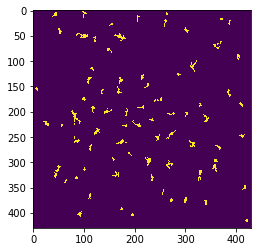

In [38]:
plt.imshow(qq)


# Compute Thresholds in Local Activity filter

In [4]:
path = '/media/DATA/jbonato/segm_project/set/'
res = np.empty((4,2,25))
fov = 0
for j in range(1,26):
    if j !=20:
        
        if len(str(j))==1:
            test_folder_str='00'+str(j)
        else:
            test_folder_str='0'+str(j)
        
        path_f = path+str(j)+'/'
        item = glob.glob(path_f+'*')
        print(path_f,item)

        stack = io.imread(item[0])
        T,N,_ = stack.shape
        
        Res_file_path='/media/DATA/jbonato/segm_project/set/dataset/SMALL_'+test_folder_str+'_nf.hdf5'
        Res_mat = np.empty((N,N,2))
        dset= h5py.File(Res_file_path,'r') 
        Res_mat[:,:,0] =  np.asarray(dset['Values'])
        Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])


        maskGT = np.sum(Res_mat,axis=2)
        maskGT[maskGT>1]=1
        
        th_res = tune_th(stack,mask=Res_mat,BB_dim=86)
        thre = th_res.save_im()
        if j>20:
            res[:,:,j-1] = thre
        else:
            res[:,:,j] = thre



/media/DATA/jbonato/segm_project/set/1/ ['/media/DATA/jbonato/segm_project/set/1/TSeries-04082019-1513-1250_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/2/ ['/media/DATA/jbonato/segm_project/set/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/3/ ['/media/DATA/jbonato/segm_project/set/3/TSeries-04082019-1513-1252_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/4/ ['/media/DATA/jbonato/segm_project/set/4/TSeries-04112019-1605-1257_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/5/ ['/media/DATA/jbonato/segm_project/set/5/TSeries-04112019-1605-1258_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/6/ ['/media/DATA/jbonato/segm_project/set/6/TSeries-04112019-1605-1266_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/7/ ['/media/DATA/jbonato/segm_project/set/7/TSeries-04112019-1605-1267_Ch2__movie_corrected_aligned

(4, 2)


Text(0.5, 1.0, 'Processes')

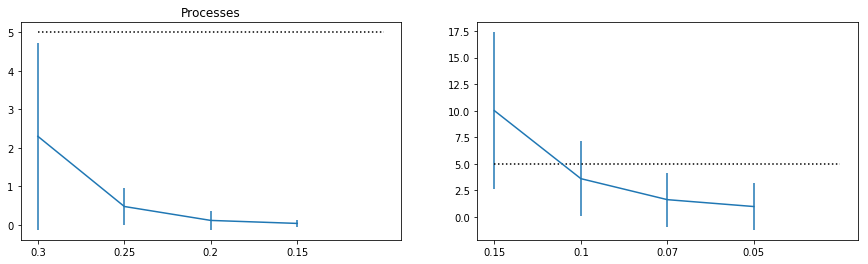

In [11]:
vec = np.mean(res,axis=2)
err = np.std(res,axis=2)
print(vec.shape)
fig,[ax1,ax2] = plt.subplots(figsize=(15,4),ncols=2,nrows=1)
ax1.errorbar(np.arange(4),vec[:,0],yerr=err[:,0])
ax2.errorbar(np.arange(4),vec[:,1],yerr=err[:,1])
ax1.set_xticks(np.arange(4))
ax2.set_xticks(np.arange(4))
ax1.set_xticklabels([0.3,0.25,0.20,0.15])
ax2.set_xticklabels([0.15,0.1,0.07,0.05])
ax1.hlines(xmin=0,xmax=4,y=5,linestyles='dotted')
ax2.hlines(xmin=0,xmax=4,y=5,linestyles='dotted')
ax1.set_title('Somata')
ax1.set_title('Processes')

In [14]:
dict_param['th1_p']=0.25
dict_param['th2_p']=0.1

# Activity Map Generator: Set percentile

In [3]:
path = '/media/DATA/jbonato/segm_project/set/'
res = np.empty((24,7))
fov = 0
for j in range(1,26):
    if j !=20:
        
        if len(str(j))==1:
            test_folder_str='00'+str(j)
        else:
            test_folder_str='0'+str(j)
        
        path_f = path+str(j)+'/'
        item = glob.glob(path_f+'*')
        print(path_f,item)

        stack = io.imread(item[0])
        T,N,_ = stack.shape
        
        Res_file_path='/media/DATA/jbonato/segm_project/set/dataset/SMALL_'+test_folder_str+'_nf.hdf5'
        Res_mat = np.empty((N,N,2))
        dset= h5py.File(Res_file_path,'r') 
        Res_mat[:,:,0] =  np.asarray(dset['Values'])
        Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])


        maskGT = np.sum(Res_mat,axis=2)
        maskGT[maskGT>1]=1
        iter_ = 0
        for i in [30,40,50,60,70,80,90]:
            
            dict_param['percentile'] = i 
            
            mask = sel_active_reg_gpu(stack,dict_param,verbose=False)
            res[fov,iter_] = f1_score(maskGT.flatten(), mask.flatten(), average='binary')
            iter_+=1
        fov+=1

/media/DATA/jbonato/segm_project/set/1/ ['/media/DATA/jbonato/segm_project/set/1/TSeries-04082019-1513-1250_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/2/ ['/media/DATA/jbonato/segm_project/set/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/3/ ['/media/DATA/jbonato/segm_project/set/3/TSeries-04082019-1513-1252_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/4/ ['/media/DATA/jbonato/segm_project/set/4/TSeries-04112019-1605-1257_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/5/ ['/media/DATA/jbonato/segm_project/set/5/TSeries-04112019-1605-1258_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/6/ ['/media/DATA/jbonato/segm_project/set/6/TSeries-04112019-1605-1266_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/segm_project/set/7/ ['/media/DATA/jbonato/segm_project/set/7/TSeries-04112019-1605-1267_Ch2__movie_corrected_aligned

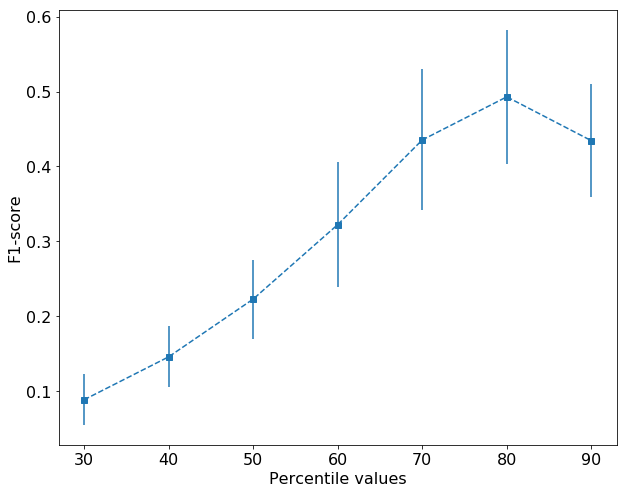

In [5]:
fig, ax = plt.subplots(figsize=(10,8),ncols = 1, nrows = 1)

ax.errorbar(np.arange(7),np.nanmean(res,axis=0),yerr=np.nanstd(res,axis=0),fmt='--', marker='s')
ax.set_xticklabels(labels =[0,30,40,50,60,70,80,90],fontsize=16)

ax.set_xlabel('Percentile values',fontsize=16)
ax.set_ylabel('F1-score',fontsize=16)
ax.tick_params(axis="y", labelsize=16)


In [15]:
dict_param['percentile']=80

# Save Dictionary values

In [16]:
set_dir='/media/DATA/jbonato/astro_segm/set/.tmp/'

if not(os.path.exists(set_dir)):
    os.mkdir(set_dir)
    print('Created',set_dir)
    
with open(set_dir+'dict_dataset1.txt', "wb") as fp:   #Pickling
    pickle.dump(dict_param, fp)

{'list': [0, 40, 80, 120, 160],
 'blocks': 15,
 'threads': 32,
 'BPM_ratio': 3,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5}

{'list': [0, 40, 80, 120, 160],
 'blocks': 15,
 'threads': 32,
 'BPM_ratio': 3,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5}